In [1]:
# Colab: run once
!pip install -q pandas numpy scikit-learn lightgbm joblib matplotlib seaborn


In [2]:
# Cell 2: mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Choose output dir
OUTPUT_DIR = "/content/drive/MyDrive/SmartSpend"  # change if you don't want Drive
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Outputs will be saved to:", OUTPUT_DIR)


Mounted at /content/drive
Outputs will be saved to: /content/drive/MyDrive/SmartSpend


In [4]:
# Cell 3: load dataset (expects smartspend_combined.csv in working dir or OUTPUT_DIR)
import os, pandas as pd

# Try current dir first, then OUTPUT_DIR
CSV_CANDIDATES = ["smartspend_combined.csv", os.path.join(OUTPUT_DIR, "smartspend_combined.csv")]
csv_path = None
for p in CSV_CANDIDATES:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("smartspend_combined.csv not found. Upload it to Colab or Drive and set OUTPUT_DIR accordingly.")

print("Loading:", csv_path)
df = pd.read_csv(csv_path, parse_dates=['timestamp'], low_memory=False)
print("Rows:", len(df))
df.head()


Loading: smartspend_combined.csv
Rows: 23906


,timestamp,raw_text,amount,currency,merchant,category,user_id,source_file
0,2025-04-23 00:00:00,Exactly fish let whom media.,994.48,NaN,Staples,Supplies,3472.0,e61d6d95-0b11-4120-95de-8c71a62776fc.xlsx::sma...
1,2025-05-18 00:00:00,Common alone identify threat against old.,1367.62,NaN,Google,Travel,5081.0,e61d6d95-0b11-4120-95de-8c71a62776fc.xlsx::sma...
2,2024-12-12 00:00:00,Wish relationship by poor amount.,1362.82,NaN,Apple,Supplies,2823.0,e61d6d95-0b11-4120-95de-8c71a62776fc.xlsx::sma...
3,2025-05-22 00:00:00,Thing behind world level organization.,302.64,NaN,Uber,Supplies,1672.0,e61d6d95-0b11-4120-95de-8c71a62776fc.xlsx::sma...
4,2025-06-05 00:00:00,Part ask special billion child fight dog imagine.,413.20,NaN,LinkedIn,Training,8065.0,e61d6d95-0b11-4120-95de-8c71a62776fc.xlsx::sma...


In [5]:
# Cell 4: basic cleaning and ensure canonical columns present
import numpy as np
expected = ['timestamp','raw_text','amount','currency','merchant','category','user_id','source_file']
for c in expected:
    if c not in df.columns:
        df[c] = np.nan

df['raw_text'] = df['raw_text'].fillna('').astype(str)
df['merchant'] = df['merchant'].fillna('').astype(str)
df['amount'] = pd.to_numeric(df['amount'], errors='coerce').fillna(0.0)
df['category'] = df['category'].fillna('').astype(str).str.strip()
# drop empty rows
df = df[~((df['raw_text'].str.strip()=='') & (df['amount']==0.0))].copy()
print("After cleaning rows:", len(df))


After cleaning rows: 23905


Top categories (original):
category
Shopping            17650
Other                2937
Salary               1354
Utilities             245
Travel                237
Rent                  165
Entertainment         155
Health & Fitness      152
Food & Drink          149
Investment            142
Dining                105
Training              100
Supplies               91
Equipment              86
Meals                  84
Healthcare             70
Software               62
Transport              44
Groceries              43
Subscriptions          34
Name: count, dtype: int64


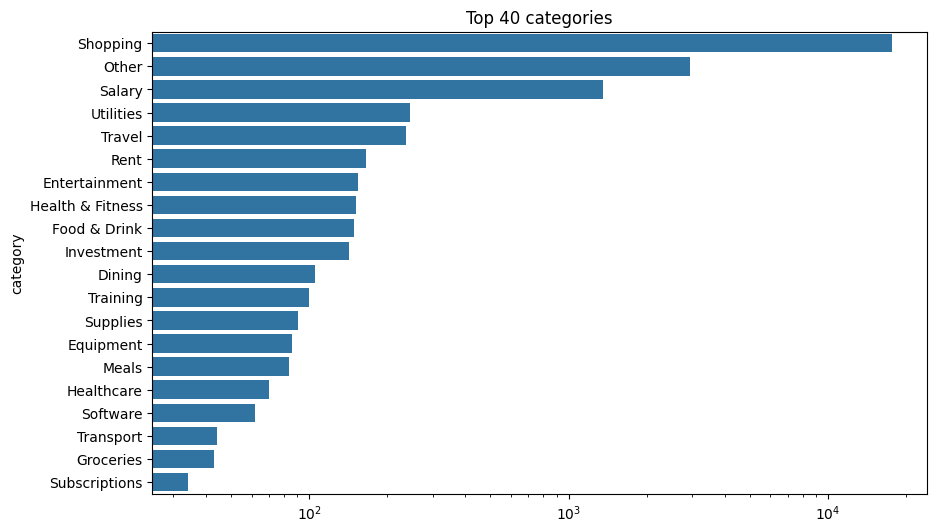

In [6]:
# Cell 5: quick EDA
import matplotlib.pyplot as plt
import seaborn as sns

print("Top categories (original):")
print(df['category'].value_counts().head(30))

plt.figure(figsize=(10,6))
vc = df['category'].value_counts().nlargest(40)
sns.barplot(x=vc.values, y=vc.index)
plt.title("Top 40 categories")
plt.xscale('log')  # log for readability
plt.show()


In [7]:
# Cell 6: category merging (edit merge_map as desired)
merge_map = {
    'Meals':'Food', 'Dining':'Food', 'Food & Drink':'Food', 'Restaurant':'Food',
    'Supplies':'Office', 'Equipment':'Office',
    'Entertainment':'Leisure', 'Travel':'Leisure', 'Movie':'Leisure', 'Theater':'Leisure',
    'Training':'Education', 'Course':'Education'
    # add more mappings if you want
}

df['category_merged'] = df['category'].map(lambda x: merge_map.get(x, x))
# collapse ultra-rare labels into 'Other'
counts = df['category_merged'].value_counts()
RARE_THRESHOLD = 50
rare = counts[counts < RARE_THRESHOLD].index.tolist()
df['category_merged'] = df['category_merged'].apply(lambda x: 'Other' if x in rare else x)

print("Counts after merging/collapsing:")
print(df['category_merged'].value_counts().head(50))


Counts after merging/collapsing:
category_merged
Shopping            17650
Other                3058
Salary               1354
Leisure               392
Food                  338
Utilities             245
Office                177
Rent                  165
Health & Fitness      152
Investment            142
Education             100
Healthcare             70
Software               62
Name: count, dtype: int64


In [8]:
# Cell 7: balancing dataset
import numpy as np
from sklearn.model_selection import train_test_split
import joblib, os

OUT_BAL = os.path.join(OUTPUT_DIR, "balanced_artifacts")
os.makedirs(OUT_BAL, exist_ok=True)

TARGET_PER_CLASS = 3000   # tweakable; lower if memory/time concerns
RANDOM_STATE = 42
rng = np.random.RandomState(RANDOM_STATE)

classes = df['category_merged'].value_counts().index.tolist()
balanced_parts = []
for cls in classes:
    subset = df[df['category_merged']==cls]
    n = len(subset)
    if n == 0:
        continue
    if n > TARGET_PER_CLASS:
        # undersample
        picked = subset.sample(n=TARGET_PER_CLASS, replace=False, random_state=rng.randint(1e9))
        balanced_parts.append(picked)
    elif n == TARGET_PER_CLASS:
        balanced_parts.append(subset)
    else:
        reps = int(np.ceil(TARGET_PER_CLASS / n))
        rep_df = pd.concat([subset.sample(n=n, replace=True, random_state=rng.randint(1e9)) for _ in range(reps)], ignore_index=True)
        rep_df = rep_df.sample(n=TARGET_PER_CLASS, replace=False, random_state=rng.randint(1e9))
        balanced_parts.append(rep_df)

balanced_df = pd.concat(balanced_parts, ignore_index=True).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
print("Balanced size:", len(balanced_df))
balanced_df['category_merged'].value_counts().head(30)

# stratified split
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['category_merged'], random_state=RANDOM_STATE)
print("Train rows:", len(train_df), "Test rows:", len(test_df))

# Save CSVs
balanced_full_path = os.path.join(OUT_BAL, "balanced_full.csv")
train_path = os.path.join(OUT_BAL, "balanced_train.csv")
test_path = os.path.join(OUT_BAL, "balanced_test.csv")
balanced_df.to_csv(balanced_full_path, index=False)
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)
joblib.dump(merge_map, os.path.join(OUT_BAL, "merge_map.pkl"))
print("Saved balanced datasets to", OUT_BAL)


Balanced size: 39000
Train rows: 31200 Test rows: 7800
Saved balanced datasets to /content/drive/MyDrive/SmartSpend/balanced_artifacts


In [9]:
# Cell 8: vectorization (TF-IDF word+char) + append amount
import time, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

WORD_MAX_F = 5000
CHAR_MAX_F = 2000

train_texts = (train_df['raw_text'].fillna('') + " " + train_df['merchant'].fillna('')).astype(str)
test_texts  = (test_df['raw_text'].fillna('') + " " + test_df['merchant'].fillna('')).astype(str)

t0 = time.time()
word_vec = TfidfVectorizer(ngram_range=(1,2), analyzer='word', max_features=WORD_MAX_F, min_df=2)
char_vec = TfidfVectorizer(ngram_range=(3,5), analyzer='char', max_features=CHAR_MAX_F, min_df=2)
Xw = word_vec.fit_transform(train_texts)
Xc = char_vec.fit_transform(train_texts)
Xw_t = word_vec.transform(test_texts)
Xc_t = char_vec.transform(test_texts)
print("TF-IDF fitted in %.1f sec" % (time.time()-t0))

X_train_text = hstack([Xw, Xc], format='csr')
X_test_text  = hstack([Xw_t, Xc_t], format='csr')

def add_amount_feature(X_sparse, amounts):
    amt = np.log1p(np.clip(np.asarray(amounts).astype(float).reshape(-1,1), a_min=0, a_max=None))
    return hstack([X_sparse, csr_matrix(amt)], format='csr')

X_train_full = add_amount_feature(X_train_text, train_df[['amount']].fillna(0.0).values)
X_test_full = add_amount_feature(X_test_text, test_df[['amount']].fillna(0.0).values)
print("Final feature shapes:", X_train_full.shape, X_test_full.shape)

# Save vectorizers
import joblib
joblib.dump(word_vec, os.path.join(OUT_BAL, "tfidf_word_bal.pkl"))
joblib.dump(char_vec, os.path.join(OUT_BAL, "tfidf_char_bal.pkl"))
print("Saved TF-IDF vectorizers.")


TF-IDF fitted in 9.4 sec
Final feature shapes: (31200, 7001) (7800, 7001)
Saved TF-IDF vectorizers.


In [10]:
# Cell 9: train balanced model (3-fold CV)
import os, json, joblib, time
import numpy as np
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import classification_report

OUT = os.path.join(OUT_BAL, "models")
os.makedirs(OUT, exist_ok=True)

labels = sorted(train_df['category_merged'].unique())
label2idx = {l:i for i,l in enumerate(labels)}
idx2label = {i:l for l,i in label2idx.items()}

y_train = train_df['category_merged'].map(label2idx).astype(int).values
y_test  = test_df['category_merged'].map(label2idx).astype(int).values

# sample weights (inverse freq) optional — for balanced set they are less crucial
from collections import Counter
counter = Counter(y_train)
total = len(y_train)
class_weights = {cls: total/(len(counter)*count) for cls,count in counter.items()}
sample_weights = np.array([class_weights[int(lbl)] for lbl in y_train])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
test_preds = np.zeros((X_test_full.shape[0], len(labels)))
oof_preds = np.zeros((X_train_full.shape[0], len(labels)))

lgb_params = {
    'objective': 'multiclass',
    'num_class': len(labels),
    'learning_rate': 0.05,
    'num_leaves': 63,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'metric': 'multi_logloss',
    'verbose': -1,
    'seed': 42
}

fold = 0
t0 = time.time()
for tr_idx, val_idx in skf.split(X_train_full, y_train):
    fold += 1
    print(f"Fold {fold}/3")
    X_tr, X_val = X_train_full[tr_idx], X_train_full[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    w_tr = sample_weights[tr_idx]
    dtrain = lgb.Dataset(X_tr, label=y_tr, weight=w_tr)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    bst = lgb.train(
        lgb_params,
        dtrain,
        num_boost_round=1000,
        valid_sets=[dtrain, dval],
        valid_names=['train','valid'],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
    )

    oof_preds[val_idx] = bst.predict(X_val, num_iteration=bst.best_iteration)
    test_preds += bst.predict(X_test_full, num_iteration=bst.best_iteration) / 3.0
    bst.save_model(os.path.join(OUT, f"lgb_bal_fold{fold}.txt"))

print("CV training done in %.1f sec" % (time.time()-t0))
# Save mapping and preds
joblib.dump({"label2idx":label2idx, "idx2label":idx2label}, os.path.join(OUT, "label_map_bal.pkl"))
import numpy as np
np.save(os.path.join(OUT, "test_preds_bal.npy"), test_preds)
np.save(os.path.join(OUT, "oof_preds_bal.npy"), oof_preds)


Fold 1/3
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.0659456	valid's multi_logloss: 0.111859
[100]	train's multi_logloss: 0.00484573	valid's multi_logloss: 0.0512984
[150]	train's multi_logloss: 0.000463046	valid's multi_logloss: 0.0557075
Early stopping, best iteration is:
[101]	train's multi_logloss: 0.00462001	valid's multi_logloss: 0.0512392
Fold 2/3
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.0661184	valid's multi_logloss: 0.108314
[100]	train's multi_logloss: 0.00497467	valid's multi_logloss: 0.0473426
[150]	train's multi_logloss: 0.000473978	valid's multi_logloss: 0.0497291
Early stopping, best iteration is:
[116]	train's multi_logloss: 0.0022943	valid's multi_logloss: 0.0467187
Fold 3/3
Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.0659244	valid's multi_logloss: 0.109502
[100]	train's multi_logloss: 0.00497596	valid's multi_logloss: 0.048589

In [11]:
# Cell 10: evaluation (fix label types and print reports)
import numpy as np, json, os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

OUT = os.path.join(OUT_BAL, "models")
labels_list = labels  # idx->name
oof_indices = np.argmax(oof_preds, axis=1)
test_indices = np.argmax(test_preds, axis=1)
oof_pred_labels = [labels_list[int(i)] for i in oof_indices]
test_pred_labels = [labels_list[int(i)] for i in test_indices]
true_train_labels = train_df['category_merged'].astype(str).tolist()
true_test_labels  = test_df['category_merged'].astype(str).tolist()

print("OOF classification report:")
oof_report = classification_report(true_train_labels, oof_pred_labels, zero_division=0)
print(oof_report)
print("Test classification report:")
test_report = classification_report(true_test_labels, test_pred_labels, zero_division=0)
print(test_report)

# save metrics
metrics = {"oof_report": oof_report, "test_report": test_report}
with open(os.path.join(OUT, "metrics_text.txt"), "w") as f:
    f.write("OOF\n")
    f.write(oof_report)
    f.write("\n\nTEST\n")
    f.write(test_report)
print("Saved metrics text to", os.path.join(OUT, "metrics_text.txt"))

# confusion matrix normalized
def plot_cm(true, pred, title, path_png):
    labs = sorted(list(set(true)|set(pred)))
    cm = confusion_matrix(true, pred, labels=labs)
    cmn = cm.astype('float') / (cm.sum(axis=1, keepdims=True)+1e-12)
    plt.figure(figsize=(10,8))
    sns.heatmap(cmn, xticklabels=labs, yticklabels=labs, cmap="Blues", annot=False)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(path_png)
    plt.close()

plot_cm(true_train_labels, oof_pred_labels, "OOF Confusion Matrix (norm)", os.path.join(OUT, "confusion_oof_norm.png"))
plot_cm(true_test_labels, test_pred_labels, "Test Confusion Matrix (norm)", os.path.join(OUT, "confusion_test_norm.png"))
print("Saved confusion matrices to", OUT)


OOF classification report:
                  precision    recall  f1-score   support

       Education       1.00      1.00      1.00      2400
            Food       0.99      0.99      0.99      2400
Health & Fitness       0.99      1.00      1.00      2400
      Healthcare       1.00      1.00      1.00      2400
      Investment       0.97      1.00      0.99      2400
         Leisure       0.97      0.99      0.98      2400
          Office       0.99      1.00      1.00      2400
           Other       1.00      0.95      0.97      2400
            Rent       0.99      1.00      0.99      2400
          Salary       1.00      0.97      0.98      2400
        Shopping       0.99      0.99      0.99      2400
        Software       1.00      1.00      1.00      2400
       Utilities       0.99      1.00      0.99      2400

        accuracy                           0.99     31200
       macro avg       0.99      0.99      0.99     31200
    weighted avg       0.99      0.99      

In [12]:
# Fix timestamps, forecast top categories, and plot results (copy-paste and run)
import pandas as pd, numpy as np, os
from pathlib import Path
import matplotlib.pyplot as plt

# REQUIRE: balanced_df must exist in the notebook
assert 'balanced_df' in globals(), "balanced_df not found. Run the balancing cell first."

# Output folder
OUT = Path("balanced_artifacts/forecasts")
OUT.mkdir(parents=True, exist_ok=True)

# 1) Convert timestamp column to datetime (in place)
print("Before conversion dtype:", balanced_df['timestamp'].dtype)
balanced_df['timestamp'] = pd.to_datetime(balanced_df['timestamp'], errors='coerce')
print("After conversion dtype:", balanced_df['timestamp'].dtype)

# 2) Count missing timestamps
missing_ts = balanced_df['timestamp'].isna().sum()
print(f"Rows with invalid/missing timestamp: {missing_ts} / {len(balanced_df)}")

if missing_ts > 0:
    # Assign safe sequential pseudo-dates for missing timestamps
    # Find a start date far in past that won't collide with real dates
    start = pd.Timestamp('2000-01-01')
    # indices with missing ts
    miss_idx = balanced_df[balanced_df['timestamp'].isna()].index
    print("Assigning pseudo-dates to missing timestamps (keeps rows).")
    for i, idx in enumerate(miss_idx):
        balanced_df.at[idx, 'timestamp'] = start + pd.Timedelta(days=i)
    # verify none missing now
    print("Missing after fill:", balanced_df['timestamp'].isna().sum())

# 3) Ensure timestamps sorted (not required but helpful)
balanced_df = balanced_df.sort_values('timestamp').reset_index(drop=True)

# 4) Choose top categories to forecast
TOP_N = 5
top_categories = balanced_df['category_merged'].value_counts().nlargest(TOP_N).index.tolist()
print("Top categories to forecast:", top_categories)

# 5) Prophet availability
try:
    from prophet import Prophet
    PROPHET = True
    print("Prophet available — will use it where possible.")
except Exception as e:
    PROPHET = False
    print("Prophet not available — using naive mean forecasts. (Install prophet if you want advanced forecasts.)")

# helper to aggregate and forecast
def forecast_and_plot(cat, periods=30, outdir=OUT):
    cat_df = balanced_df[balanced_df['category_merged'] == cat].copy()
    # daily aggregation using DatetimeIndex grouping
    ts = cat_df.groupby(pd.Grouper(key='timestamp', freq='D'))['amount'].sum().reset_index().rename(columns={'timestamp':'ds','amount':'y'}).sort_values('ds')
    ts = ts.reset_index(drop=True)
    print(f"Category '{cat}' has {len(ts)} daily points; total sum={ts['y'].sum():.2f}")
    if len(ts) < 10 or ts['y'].sum() == 0:
        # naive forecast
        mean_val = float(ts['y'].mean()) if len(ts)>0 else 0.0
        future_dates = pd.date_range(start=(ts['ds'].max() if len(ts)>0 else pd.Timestamp('2000-01-01')), periods=periods+1, closed='right')
        forecast = pd.DataFrame({'ds': future_dates, 'yhat': mean_val, 'yhat_lower': mean_val*0.9, 'yhat_upper': mean_val*1.1})
        method = "naive (insufficient data or zero sum)"
    else:
        if PROPHET:
            try:
                m = Prophet()
                m.fit(ts)
                future = m.make_future_dataframe(periods=periods)
                fcst = m.predict(future)
                forecast = fcst[['ds','yhat','yhat_lower','yhat_upper']].tail(periods)
                method = "prophet"
            except Exception as e:
                # fallback to naive if prophet fails for this TS
                mean_val = float(ts['y'].mean())
                future_dates = pd.date_range(start=ts['ds'].max(), periods=periods+1, closed='right')
                forecast = pd.DataFrame({'ds': future_dates, 'yhat': mean_val, 'yhat_lower': mean_val*0.9, 'yhat_upper': mean_val*1.1})
                method = f"naive (prophet failed: {e})"
        else:
            mean_val = float(ts['y'].mean())
            future_dates = pd.date_range(start=ts['ds'].max(), periods=periods+1, closed='right')
            forecast = pd.DataFrame({'ds': future_dates, 'yhat': mean_val, 'yhat_lower': mean_val*0.9, 'yhat_upper': mean_val*1.1})
            method = "naive (prophet unavailable)"
    # Save forecast CSV
    safe_name = "".join(ch if ch.isalnum() or ch in (' ','_','-') else '_' for ch in cat).replace(' ','_')[:60]
    csv_path = outdir / f"forecast_{safe_name}.csv"
    forecast.to_csv(csv_path, index=False)
    # Plot history + forecast
    plt.figure(figsize=(10,5))
    # plot historical (last 180 days for clarity if many)
    hist = ts.copy()
    if len(hist) > 180:
        hist = hist.tail(180)
    plt.plot(hist['ds'], hist['y'], label='history')
    # plot forecast
    plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
    plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
    plt.title(f"Category: {cat}  ({method})")
    plt.xlabel("Date")
    plt.ylabel("Daily amount sum")
    plt.legend()
    png_path = outdir / f"forecast_{safe_name}.png"
    plt.tight_layout()
    plt.savefig(png_path)
    plt.close()
    return {"category": cat, "method": method, "ts_rows": len(ts), "csv": str(csv_path), "plot": str(png_path)}

# 6) Run for top categories and print results
results = []
for c in top_categories:
    info = forecast_and_plot(c, periods=30, outdir=OUT)
    print(f"Saved forecast for '{info['category']}' -> csv: {info['csv']}, plot: {info['plot']}, method: {info['method']}, ts_rows: {info['ts_rows']}")
    results.append(info)

print("Forecasts and plots saved to:", OUT)


Before conversion dtype: object
After conversion dtype: datetime64[ns]
Rows with invalid/missing timestamp: 2099 / 39000
Assigning pseudo-dates to missing timestamps (keeps rows).
Missing after fill: 0
Top categories to forecast: ['Other', 'Shopping', 'Food', 'Utilities', 'Salary']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet available — will use it where possible.
Category 'Other' has 9130 daily points; total sum=29792346402780434432.00


/tmp/ipython-input-2241084085.py:97: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Saved forecast for 'Other' -> csv: balanced_artifacts/forecasts/forecast_Other.csv, plot: balanced_artifacts/forecasts/forecast_Other.png, method: prophet, ts_rows: 9130
Category 'Shopping' has 8993 daily points; total sum=4036336778252367953920.00


/tmp/ipython-input-2241084085.py:97: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Saved forecast for 'Shopping' -> csv: balanced_artifacts/forecasts/forecast_Shopping.csv, plot: balanced_artifacts/forecasts/forecast_Shopping.png, method: prophet, ts_rows: 8993
Category 'Food' has 9428 daily points; total sum=493046956263526432768.00


/tmp/ipython-input-2241084085.py:97: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Saved forecast for 'Food' -> csv: balanced_artifacts/forecasts/forecast_Food.csv, plot: balanced_artifacts/forecasts/forecast_Food.png, method: prophet, ts_rows: 9428
Category 'Utilities' has 9090 daily points; total sum=581865160796733177856.00


/tmp/ipython-input-2241084085.py:97: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Saved forecast for 'Utilities' -> csv: balanced_artifacts/forecasts/forecast_Utilities.csv, plot: balanced_artifacts/forecasts/forecast_Utilities.png, method: prophet, ts_rows: 9090
Category 'Salary' has 9098 daily points; total sum=1691503443964084092928.00


/tmp/ipython-input-2241084085.py:97: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  plt.fill_between(forecast['ds'].dt.to_pydatetime(), forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)


Saved forecast for 'Salary' -> csv: balanced_artifacts/forecasts/forecast_Salary.csv, plot: balanced_artifacts/forecasts/forecast_Salary.png, method: prophet, ts_rows: 9098
Forecasts and plots saved to: balanced_artifacts/forecasts


In [18]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# y_true and y_pred must be STRING labels (we already fixed this earlier)
y_true = true_test_labels          # ground truth labels (strings)
y_pred = test_pred_labels          # predicted labels (strings)

cm = confusion_matrix(y_true, y_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix (counts):")
display(cm_df)


Confusion Matrix (counts):


,Education,Food,Health & Fitness,Healthcare,Investment,Leisure,Office,Other,Rent,Salary,Shopping,Software,Utilities
Education,600,0,0,0,0,0,0,0,0,0,0,0,0
Food,0,600,0,0,0,0,0,0,0,0,0,0,0
Health & Fitness,0,0,600,0,0,0,0,0,0,0,0,0,0
Healthcare,0,0,0,600,0,0,0,0,0,0,0,0,0
Investment,0,0,0,0,600,0,0,0,0,0,0,0,0
Leisure,0,0,0,0,0,596,4,0,0,0,0,0,0
Office,0,0,0,0,0,0,600,0,0,0,0,0,0
Other,0,0,2,1,12,3,0,580,1,0,1,0,0
Rent,0,0,0,0,0,0,0,0,600,0,0,0,0
Salary,0,2,1,0,0,6,0,0,1,586,0,0,4
